<a href="https://colab.research.google.com/github/shahin-ro/Table-Detection/blob/main/Table_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y tesseract-ocr tesseract-ocr-fas
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  tesseract-ocr-fas
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 301 kB of archives.
After this operation, 446 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-fas all 1:4.00~git30-7274cfa-1.1 [301 kB]
Fetched 301 kB in 1s (535 kB/s)
Selecting previously unselected package tesseract-ocr-fas.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-fas_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-fas (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-fas (1:4.00~git30-7274cfa-1.1) ...


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
import pytesseract
import pandas as pd

uploaded = files.upload()
if len(uploaded) == 0:
    raise SystemExit("No file uploaded.")
image_name = list(uploaded.keys())[0]
nparr = np.frombuffer(uploaded[image_name], np.uint8)
img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

def _cluster_coords(coords, tol=10):
    coords = np.array(sorted(coords))
    if coords.size == 0:
        return []
    clusters = []
    current = [coords[0]]
    for c in coords[1:]:
        if abs(int(c) - int(current[-1])) <= tol:
            current.append(c)
        else:
            clusters.append(int(np.mean(current)))
            current = [c]
    clusters.append(int(np.mean(current)))
    return clusters

def filter_lines(line_img, min_length=50, horizontal=True):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(line_img, connectivity=8)
    filtered = np.zeros_like(line_img)
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if horizontal and w >= min_length:
            filtered[labels == i] = 255
        elif (not horizontal) and h >= min_length:
            filtered[labels == i] = 255
    return filtered

def detect_table_cells(img, line_size_ratio=0.02, cluster_tol=10, min_cell_area=500, min_line_length=50):
    drawn = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_inv = cv2.bitwise_not(gray)
    bw = cv2.adaptiveThreshold(gray_inv, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY, 15, -2)
    h, w = bw.shape
    horizontal_size = max(1, int(w * line_size_ratio))
    vertical_size = max(1, int(h * line_size_ratio))
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
    horizontal = cv2.erode(bw, horizontal_kernel, iterations=1)
    horizontal = cv2.dilate(horizontal, horizontal_kernel, iterations=1)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
    vertical = cv2.erode(bw, vertical_kernel, iterations=1)
    vertical = cv2.dilate(vertical, vertical_kernel, iterations=1)
    horizontal_filtered = filter_lines(horizontal, min_length=min_line_length, horizontal=True)
    vertical_filtered = filter_lines(vertical, min_length=min_line_length, horizontal=False)
    mask = cv2.add(horizontal_filtered, vertical_filtered)
    joints = cv2.bitwise_and(horizontal_filtered, vertical_filtered)
    pts = cv2.findNonZero(joints)
    if pts is None:
        return [], mask, joints, drawn, [], []
    xs = [p[0][0] for p in pts]
    ys = [p[0][1] for p in pts]
    xs_unique = _cluster_coords(xs, tol=cluster_tol)
    ys_unique = _cluster_coords(ys, tol=cluster_tol)
    cells = []
    for i in range(len(xs_unique)-1):
        for j in range(len(ys_unique)-1):
            x1 = xs_unique[i]; x2 = xs_unique[i+1]
            y1 = ys_unique[j]; y2 = ys_unique[j+1]
            if x2 - x1 <= 3 or y2 - y1 <= 3:
                continue
            area = (x2 - x1) * (y2 - y1)
            if area < min_cell_area:
                continue
            cells.append((x1, y1, x2, y2))
            cv2.rectangle(drawn, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return cells, mask, joints, drawn, xs_unique, ys_unique

cells, mask, joints, drawn, xs_unique, ys_unique = detect_table_cells(img, line_size_ratio=0.02, cluster_tol=10, min_cell_area=800, min_line_length=50)
print(f"✅ Detected {len(cells)} cells.")

Saving Untitled1.jpg to Untitled1.jpg
✅ Detected 50 cells.


In [ ]:
text_with_coords = []
for idx, (x1, y1, x2, y2) in enumerate(cells):
    cell_img = img[y1:y2, x1:x2]
    gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
    _, th_cell = cv2.threshold(gray_cell, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    text = pytesseract.image_to_string(th_cell, lang='fas').strip()
    text_with_coords.append({'text': text, 'coords': (x1, y1, x2, y2)})
    print(f"متن سلول {idx+1}: {text}")
    print(f"مختصات: {(x1, y1, x2, y2)}")
    print('---')

متن سلول 1: 
مختصات: (32, 52, 185, 103)
---
متن سلول 2: 
مختصات: (32, 103, 185, 157)
---
متن سلول 3: 
مختصات: (32, 157, 185, 199)
---
متن سلول 4: وله ۱۳
مختصات: (32, 199, 185, 234)
---
متن سلول 5: 
مختصات: (32, 234, 185, 282)
---
متن سلول 6: 
مختصات: (32, 282, 185, 341)
---
متن سلول 7: 
مختصات: (32, 341, 185, 396)
---
متن سلول 8: 
مختصات: (32, 396, 185, 462)
---
متن سلول 9: 
مختصات: (32, 462, 185, 521)
---
متن سلول 10: تیاده مبنننگ اسآ ۳
مختصات: (32, 521, 185, 559)
---
متن سلول 11: 
مختصات: (185, 52, 261, 103)
---
متن سلول 12: ۰ اه تما
مختصات: (185, 103, 261, 157)
---
متن سلول 13: 
مختصات: (185, 157, 261, 199)
---
متن سلول 14: 
مختصات: (185, 199, 261, 234)
---
متن سلول 15: 
مختصات: (185, 234, 261, 282)
---
متن سلول 16: 
مختصات: (185, 282, 261, 341)
---
متن سلول 17: 
مختصات: (185, 341, 261, 396)
---
متن سلول 18: 
مختصات: (185, 396, 261, 462)
---
متن سلول 19: 
مختصات: (185, 462, 261, 521)
---
متن سلول 20: 
مختصات: (185, 521, 261, 559)
---
متن سلول 21: 
مختصات: (261, 52, 372, 103)
---
متن

In [ ]:
table_dict = {}
for idx, (x1, y1, x2, y2) in enumerate(cells):
    x_center = (x1 + x2) // 2
    y_center = (y1 + y2) // 2
    col_idx = min(range(len(xs_unique)), key=lambda i: abs(xs_unique[i] - x_center))
    row_idx = min(range(len(ys_unique)), key=lambda i: abs(ys_unique[i] - y_center))
    table_dict[(row_idx, col_idx)] = text_with_coords[idx]['text']

max_row = max(k[0] for k in table_dict.keys()) + 1
max_col = max(k[1] for k in table_dict.keys()) + 1

data = []
for r in range(max_row):
    row_data = []
    for c in range(max_col):
        row_data.append(table_dict.get((r,c), ""))
    data.append(row_data)

df = pd.DataFrame(data)
print("جدول استخراج شده (متن داخل سلول‌ها):")
print(df)

جدول استخراج شده (متن داخل سلول‌ها):
                    0         1                  2                  3       4
0                                                                            
1                      ۰ اه تما                                        بتلی 0
2                                                                            
3              وله ۱۳                                                        
4                                پزشک پتری کتلهد ‏                           
5                                                   تیه لیم\n\nفا مسق        
6                                                                            
7                                                                            
8                                                                            
9  تیاده مبنننگ اسآ ۳                ساعت تس تکلی.                           


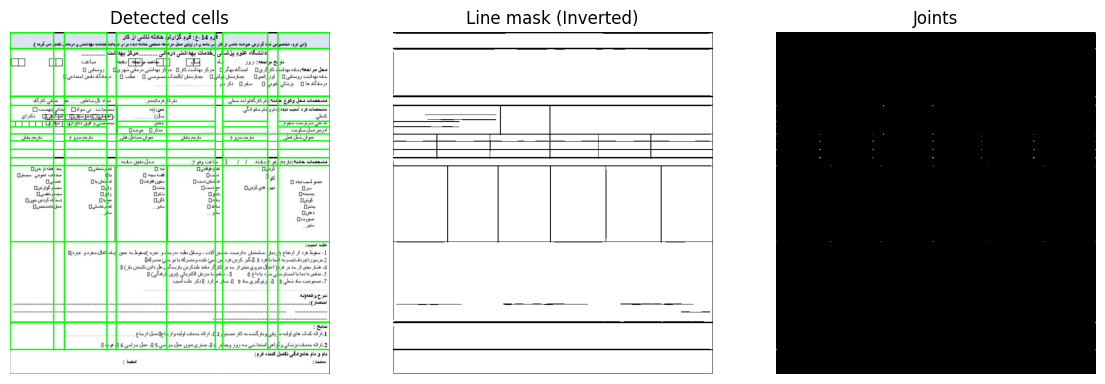

In [ ]:
mask_inverted = cv2.bitwise_not(mask)
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.title("Detected cells")
plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,3,2)
plt.title("Line mask (Inverted)")
plt.imshow(mask_inverted, cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title("Joints")
plt.imshow(joints, cmap='gray')
plt.axis('off')
plt.show()